# Group Classes Using NDVI


* **Products used:** 
[gm_s2_annual](https://explorer.digitalearth.africa/gm_s2_annual), 
[gm_s2_semiannual](https://explorer.digitalearth.africa/gm_s2_semiannual), 
[fc_ls_summary_annual](https://explorer.digitalearth.africa/fc_ls_summary_annual),
[s2_l2a](https://explorer.digitalearth.africa/products/s2_l2a)

## Background

## Description


---

## Getting Started

To run this analysis, run all the cells in the notebook, starting with the "**Load packages**" cell.

### Load packages

In [1]:
import gc
import os
import pickle
import pprint

import datacube
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from datacube.utils import geometry
from datacube.utils.geometry import CRS, Geometry
from deafrica_tools.bandindices import calculate_indices
from deafrica_tools.classification import sklearn_flatten, sklearn_unflatten
from deafrica_tools.dask import create_local_dask_cluster
from deafrica_tools.datahandling import load_ard
from deafrica_tools.plotting import rgb
from deafrica_tools.spatial import xr_rasterize
from deafrica_tools.temporal import temporal_statistics, xr_phenology
from random_sampling import random_sampling
from sklearn.cluster import DBSCAN, KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

### Set up a Dask cluster

Dask can be used to better manage memory use and conduct the analysis in parallel. 
For an introduction to using Dask with Digital Earth Africa, see the [Dask notebook](../Beginners_guide/08_Parallel_processing_with_dask.ipynb).

>**Note**: We recommend opening the Dask processing window to view the different computations that are being executed; to do this, see the *Dask dashboard in DE Africa* section of the [Dask notebook](../Beginners_guide/08_Parallel_processing_with_dask.ipynb).

To use Dask, set up the local computing cluster using the cell below.

In [2]:
create_local_dask_cluster()

Client Scheduler: tcp://127.0.0.1:35013 Dashboard: /user/victoria@kartoza.com/proxy/8787/status,Cluster Workers: 1 Cores: 4 Memory: 28.14 GB


### Analysis parameters

The following cell sets important parameters for the analysis:

* `output_dir` : The directory in which to store results from the analysis.
* `no_of_clusters` : The number of clusters used in the K-Means clustering in the [previous notebook](01_unsupervised_class_identification.ipynb).
* `time_01` : This is the time period of interest from the [previous notebook](01_unsupervised_class_identification.ipynb).
* `resolution` : The spatial resolution, in metres, to resample the satellite data to from the [previous notebook](01_unsupervised_class_identification.ipynb).
* `output_crs` : The coordinate reference system that the loaded data is to be reprojected to from the [previous notebook](01_unsupervised_class_identification.ipynb).
* `dask_chunks`: the size of the dask chunks, dask breaks data into manageable chunks that can be easily stored in memory, e.g. dict(x=1000,y=1000) from the [previous notebook](01_unsupervised_class_identification.ipynb).
* `kmeans_predicted_fp` : The file path to the prediction results from the [previous notebook](01_unsupervised_class_identification.ipynb).
* `time` : This is the time period of interest to load data for.

**If running the notebook for the first time**, keep the default settings below.
This will demonstrate how the analysis works and provide meaningful results.

In [3]:
# Directory to store the results.
output_dir = "results"

# The number of clusters used in the K-Means clustering in the previous notebook.
no_of_clusters = 15

# Time period of interest from the previous notebook.
time_01 = "2021"

# Resolution and CRS to reproject data to.
resolution = (-20, 20)
output_crs = "EPSG:6933"

# Size of dask chunks.
dask_chunks = {"time": 1, "x": 500, "y": 500}

# Prediction results from the previouse notebook.
kmeans_predicted_fp = (
    f"{output_dir}/kmeans_{no_of_clusters}_classes_predicted_{time_01}.geojson"
)

# Time period of interest.
time_02 = ("15-10-2020", "15-02-2022")

### Connect to the datacube

Connect to the datacube so we can access DE Africa data. 
The `app` parameter is a unique name for the analysis which is based on the notebook file name.

In [4]:
dc = datacube.Datacube(app="group_classes_using_ndvi")

## Read in K-means Clustering  prediction results from previous notebook

In [5]:
gdf = gpd.read_file(kmeans_predicted_fp)
gdf.head()

,Departemen,Commune,Cultures,id,predicted,geometry
0,Boboye,Kiota,mil et niébé,0,14,POINT (2.96908 13.33147)
1,Boboye,Kiota,mil et niébé,1,9,POINT (2.93870 13.25270)
2,Boboye,Kiota,mil et niébé,2,6,POINT (2.94553 13.29112)
3,Boboye,Kiota,mil et niébé,3,0,POINT (2.97375 13.28498)
4,Boboye,Kiota,mil et niébé,4,0,POINT (2.98262 13.29145)


## Compute NDVI profiles for each point

In [6]:
# Function to get the NDVI time series/profile for each point.
def get_ndvi_time_series(geom):
    # Generate a datacube query object.
    query = {
        "geopolygon": geom,
        "time": time_02,
        "resolution": resolution,
        "output_crs": output_crs,
        "dask_chunks": dask_chunks,
    }

    # Load the Sentinel-2 product.
    ds_s2 = load_ard(
        dc=dc,
        products=["s2_l2a"],
        measurements=["red", "nir"],
        # mask_filters=[("opening", 3), ("dilation", 3)],
        **query,
        verbose=False
    )

    # Calculate the NDVI spectral index.
    ds_s2 = calculate_indices(ds_s2, index="NDVI", collection="s2")
    ndvi = ds_s2.NDVI

    # Smooth the NDVI over time.
    resample_period = "2W"
    window = 4
    ndvi_smooth = (
        ndvi.resample(time=resample_period)
        .median()
        .rolling(time=window, min_periods=1)
        .mean()
    )

    # Compute the NDVI time series.
    ndvi_time_series = ndvi_smooth.mean(dim=("x", "y")).load()

    # Convert the NDVI time series xarray.Dataset to pandas Dataframe.
    ndvi_time_series_df = ndvi_time_series.to_dataframe().drop(["spatial_ref"], axis=1)

    return ndvi_time_series_df

In [7]:
%%time
# Tune the GC parameters at process startup to lessen the number of garbage collection attempts.
g0, g1, g2 = gc.get_threshold()
gc.set_threshold(g0 * 20, g1 * 20, g2 * 20)

# Compute the NDVI time series/profile for each point in the `gdf` GeoDataFrame.
id_list = gdf["id"].to_list()

# Define list to store the NDVI profiles for each point.
ndvi_time_series_list = []

for ID in id_list:
    # print(f"Feature {ID:02d}/{len(id_list)}", end='\r')
    # Transform the point into a geometry object.
    geom = geometry.Geometry(geom=gdf.iloc[ID].geometry, crs=gdf.crs)
    # Get the NDVI profile for the point.
    ndvi_time_series = get_ndvi_time_series(geom)
    # Rename the NDVI column.
    ndvi_time_series.rename(columns={"NDVI": f"{ID}"}, inplace=True)
    # Add the NDVI profile for the point to the list.
    ndvi_time_series_list.append(ndvi_time_series)

/env/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/env/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage

CPU times: user 1min 59s, sys: 5.85 s, total: 2min 5s
Wall time: 12min 52s


In [8]:
ndvi_time_series_df = pd.concat(objs=ndvi_time_series_list, axis=1, join="inner")
ndvi_time_series_df.head()

,0,1,2,3,4,5,6,7,8,9,...,73,74,75,76,77,78,79,80,81,82
time,,,,,,,,,,,,,,,,,,,,,
2020-10-18,0.230153,0.370561,0.280888,0.461396,0.328576,0.462565,0.317815,0.523631,0.453263,0.249497,...,0.206805,0.235114,0.172116,0.483058,0.364169,0.246434,0.339739,0.124206,0.124206,0.347891
2020-11-01,0.227368,0.374900,0.271527,0.460375,0.310514,0.457321,0.313088,0.549725,0.476291,0.261779,...,0.205940,0.232958,0.160582,0.470285,0.337728,0.222324,0.346074,0.119577,0.119577,0.298965
2020-11-15,0.213557,0.369740,0.243604,0.402984,0.282243,0.411375,0.277839,0.507062,0.432388,0.249209,...,0.207548,0.214551,0.154649,0.409949,0.299847,0.207078,0.332971,0.107140,0.107140,0.286415
2020-11-29,0.206422,0.366172,0.231393,0.384967,0.262650,0.381916,0.256003,0.469567,0.401816,0.233279,...,0.198412,0.206677,0.142671,0.383712,0.274431,0.187698,0.303526,0.103402,0.103402,0.263559
2020-12-13,0.191625,0.364011,0.207716,0.348124,0.229374,0.335563,0.221808,0.389362,0.336589,0.210637,...,0.187119,0.191646,0.125859,0.332420,0.227474,0.158353,0.266349,0.092825,0.092825,0.224253


In [9]:
# Export the pandas Dataframe as csv.
ndvi_time_series_df.to_csv(
    f"{output_dir}/ndvi_time_series_{time_02[0]}_to_{time_02[1]}.csv"
)

## Compute NDVI time series per k-means class

In [10]:
# Get the unique predicted classes from the `gdf` GeoDataFrame.
class_list = np.unique(gdf["predicted"])

In [11]:
# Create an empty dataframe to store the NDVI time series for each k-means class.
timeseries_df = pd.DataFrame()

# For each unique predicted_class.
for predicted_class in class_list:
    # Get the point IDs corresponding to the class.
    class_ids = list(gdf.loc[gdf["predicted"] == predicted_class, "id"])
    class_ids = [str(i) for i in class_ids]
    # Get the mean NDVI time series for the points.
    mean_ndvi_time_series = ndvi_time_series_df[class_ids].mean(axis=1)
    # Add the results to the `df` DataFrame.
    timeseries_df[f"Class_{predicted_class}"] = mean_ndvi_time_series.values


# Add the time index.
timeseries_df.index = ndvi_time_series_df.index
timeseries_df

,Class_0,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,Class_8,Class_9,Class_10,Class_11,Class_12,Class_13,Class_14
time,,,,,,,,,,,,,,,
2020-10-18,0.373664,0.272289,0.262170,0.488447,0.205157,0.126030,0.185650,0.324008,0.245716,0.370561,0.264601,0.206123,0.283214,0.261561,0.356605
2020-11-01,0.367892,0.267502,0.262727,0.513008,0.202492,0.125733,0.178545,0.292539,0.231209,0.374900,0.253009,0.210526,0.278938,0.261709,0.348827
2020-11-15,0.330659,0.248709,0.246517,0.469725,0.196633,0.118402,0.169566,0.262654,0.215685,0.369740,0.239174,0.207601,0.267401,0.248621,0.311753
2020-11-29,0.311771,0.236279,0.241981,0.435692,0.189459,0.115626,0.163263,0.245974,0.207915,0.366172,0.226947,0.203708,0.266837,0.240613,0.295067
2020-12-13,0.278055,0.215557,0.230275,0.362975,0.178986,0.110319,0.151510,0.213600,0.190349,0.364011,0.204795,0.196269,0.260148,0.228455,0.262022
2020-12-27,0.241833,0.195885,0.219923,0.279416,0.168785,0.103137,0.146435,0.195004,0.180757,0.376426,0.187545,0.185499,0.255087,0.211056,0.224584
2021-01-10,0.233491,0.187753,0.219021,0.245703,0.160229,0.103547,0.144435,0.188390,0.178213,0.374764,0.174461,0.175052,0.259152,0.209987,0.216265
2021-01-24,0.222488,0.180987,0.214742,0.234357,0.154932,0.103694,0.144346,0.186117,0.175650,0.377425,0.165754,0.170644,0.258603,0.205167,0.201543
2021-02-07,0.213039,0.174983,0.207180,0.270439,0.150047,0.104641,0.145589,0.180286,0.174384,0.356369,0.158830,0.165114,0.252391,0.199418,0.192721


In [12]:
# Export the pandas Dataframe as csv.
timeseries_df.to_csv(
    f"{output_dir}/kmeans_predicted_classes_ndvi_time_series_{time_02[0]}_to_{time_02[1]}.csv"
)

## Compute cross-correlation (Pearson Correlation) and keep maximum

In [13]:
def max_lagged_correlation(df, max_lag):
    max_lagged_correlation = pd.DataFrame.from_dict(
        {
            x: [
                max(df[x].corr(df[y].shift(-t)) for t in range(-max_lag, max_lag))
                for y in list(df.columns)
            ]
            for x in list(df.columns)
        }
    )

    return max_lagged_correlation

In [14]:
# Demean the time series NDVI before cross correlation.
demeaned_timeseries_df = timeseries_df.sub(timeseries_df.mean())

In [15]:
correlation_matrix_df = max_lagged_correlation(demeaned_timeseries_df, 3)
correlation_matrix_df.head()

,Class_0,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,Class_8,Class_9,Class_10,Class_11,Class_12,Class_13,Class_14
0,1.000000,0.986989,0.971231,0.927297,0.956404,0.665359,0.962166,0.968209,0.982814,0.841444,0.974001,0.963243,0.950066,0.982192,0.916353
1,0.986989,1.000000,0.970268,0.924808,0.941918,0.609017,0.978163,0.982529,0.980468,0.860243,0.957471,0.969922,0.967844,0.980338,0.871267
2,0.971231,0.970268,1.000000,0.910999,0.954106,0.727833,0.965746,0.932037,0.975448,0.827933,0.957547,0.956222,0.970361,0.984414,0.912467
3,0.927297,0.924808,0.910999,1.000000,0.924200,0.653968,0.919071,0.916598,0.923273,0.732445,0.945869,0.893280,0.870612,0.906137,0.907406
4,0.956404,0.941918,0.954106,0.924200,1.000000,0.797323,0.935008,0.888145,0.941137,0.856231,0.983062,0.958034,0.933030,0.965680,0.905986


## Identify Grouped Classes and Loner Classes

Grouped classes are the classes in the K_means clustering prediction image that were grouped together.

The loner classes are classes in the K_means clustering prediction image that were unable to be grouped in any way.

In [16]:
correlation_matrix_df_copy = correlation_matrix_df.copy()

grouped_classes = []
loner_classes = []

class_cols = list(correlation_matrix_df_copy.columns)

for i, column in enumerate(class_cols):

    thresh = 0.93

    single_class = correlation_matrix_df_copy[column]
    indexes_above_thresh = list(single_class[single_class >= thresh].index)

    correlation_matrix_df_copy = correlation_matrix_df_copy.drop(
        indexes_above_thresh, axis=0
    )

    # if not empty (contains at least one element)
    if len(indexes_above_thresh) == 1:
        loner_classes.extend(indexes_above_thresh)
    elif len(indexes_above_thresh) > 1:
        grouped_classes.append(indexes_above_thresh)

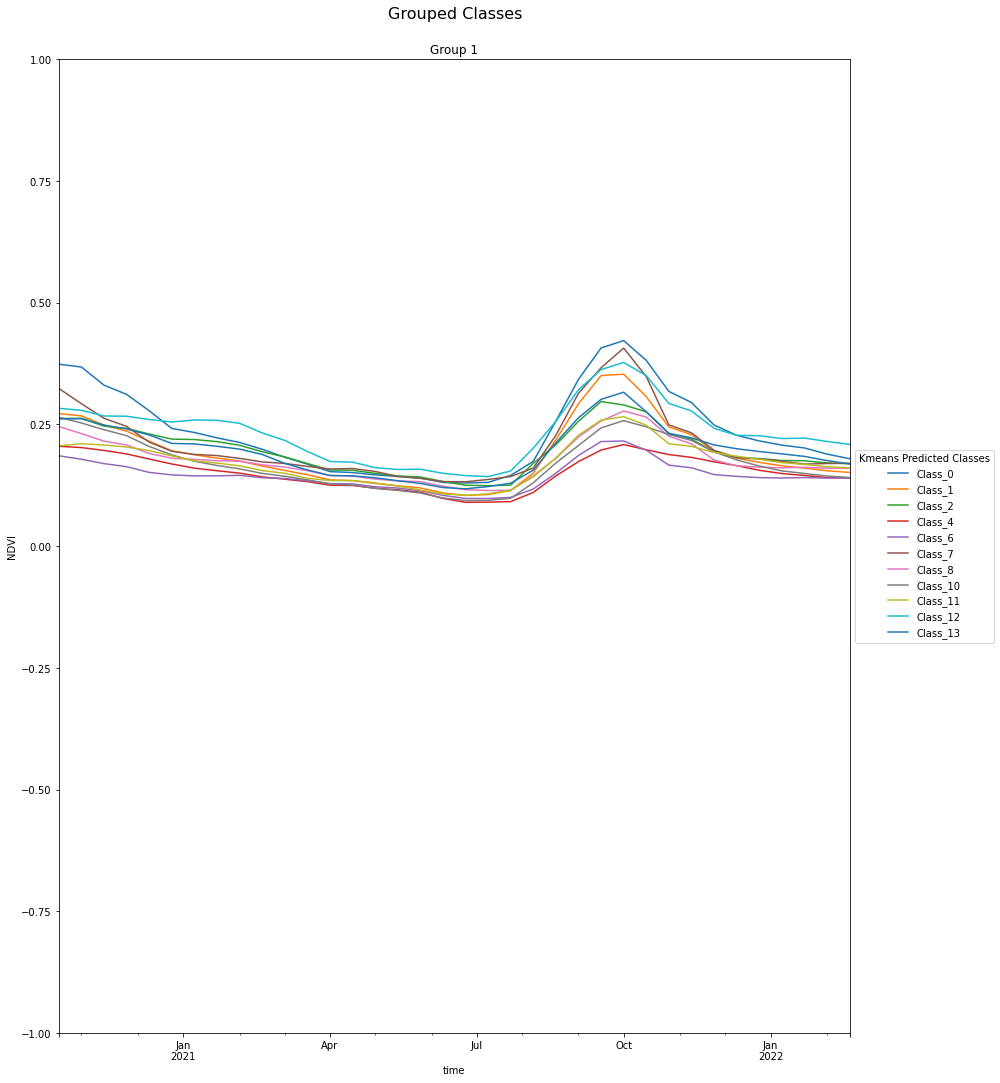

In [17]:
# Plot the grouped classes in their respective groups.
fig = plt.figure(figsize=(14, 15), facecolor="white")
fig.suptitle("Grouped Classes", x=0.455, y=1, fontsize=16)

rows = len(grouped_classes)
columns = 1

# Starting point for naming the groups.
group_name = 1

for i in range(rows):
    ax = fig.add_subplot(rows, columns, i + 1)
    timeseries_df.iloc[:, grouped_classes[i]].plot(ax=ax)
    ax.legend(
        title="Kmeans Predicted Classes", bbox_to_anchor=(1.0, 0.5), loc="center left"
    )
    ax.set_ylim((-1, 1))
    ax.set_title(f"Group {group_name}")
    ax.set_ylabel("NDVI")
    group_name += 1
plt.tight_layout()

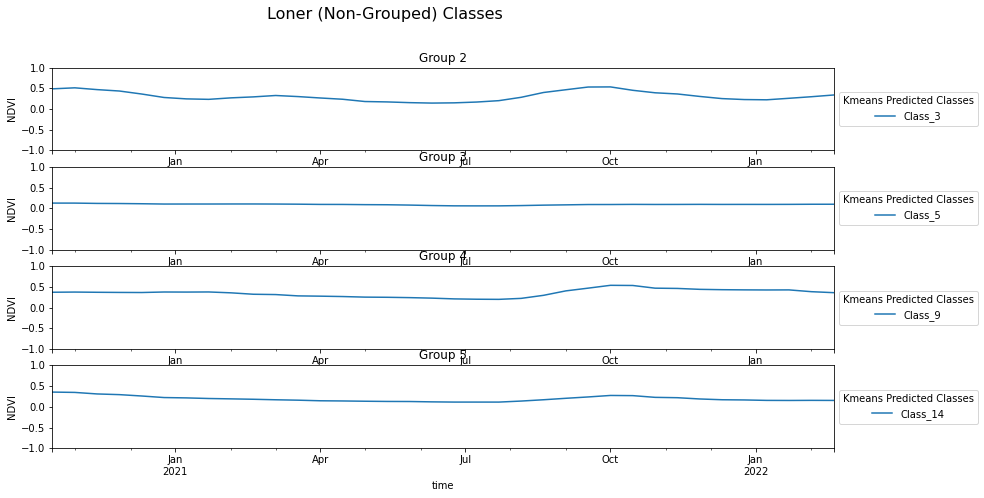

In [18]:
# Plot the loner classes. Each loner class is a group on its own.
fig = plt.figure(figsize=(14, 7), facecolor="white")
fig.suptitle("Loner (Non-Grouped) Classes", x=0.455, y=1, fontsize=16)

rows = len(loner_classes)
columns = 1

for i in range(rows):
    ax = fig.add_subplot(rows, columns, i + 1)
    timeseries_df.iloc[:, loner_classes[i]].plot(ax=ax)
    ax.legend(
        title="Kmeans Predicted Classes", bbox_to_anchor=(1.0, 0.5), loc="center left"
    )
    ax.set_ylim((-1, 1))
    ax.set_title(f"Group {group_name}")
    ax.set_ylabel("NDVI")
    group_name += 1

In [19]:
# Export the grouped classes.

# Starting point for naming the groups.
group_name = 1

for group in grouped_classes:
    class_list = [f"Class_{index}" for index in group]

    with open(
        f"{output_dir}/correlated_ndvi_{time_02[0]}_to_{time_02[1]}_{no_of_clusters}_classes_group_{group_name}.pickle",
        "wb",
    ) as f:
        pickle.dump(class_list, f, protocol=-1)

    group_name += 1

In [20]:
# Export the loner classes
class_list = [[f"Class_{loner_class}"] for loner_class in loner_classes]


with open(
    f"{output_dir}/correlated_ndvi_{time_02[0]}_to_{time_02[1]}_{no_of_clusters}_classes_loner_classes.pickle",
    "wb",
) as f:
    pickle.dump(class_list, f, protocol=-1)

## Recommended next steps

To continue working through the notebooks in this workflow, go to the next notebook `02_group_classes_using_NDVI.ipynb`.

1. [Unsupervised Class Identification](01_unsupervised_class_identification.ipynb)
2. **Group Classes Using NDVI (this notebook)**
3. [Reclassify Unsupervised NDVI](03_reclassify_unsupervised_map_NDVI_classes.ipynb)

---

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to repoart an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:**

In [21]:
print(datacube.__version__)

1.8.6


**Last Tested:**

In [22]:
from datetime import datetime

datetime.today().strftime("%Y-%m-%d")

'2022-06-30'